# Create your own pricing model

Pre-requisites: Notebook 1.1, 1.2

In this notebook we will show how you can create your own monte carlo pricing model. The `finmc` package allows you to create your own model using [MCBase](https://finlib.github.io/finmc/models/api/#finmc.models.base.MCBase) or [MCFixedStep](https://finlib.github.io/finmc/models/api/#finmc.models.base.MCFixedStep).

We will implement a simple black-scholes flat volatility model where the stock price is given by
$$ 
S_t = e^{X_t}
$$ 
where $X_t$ is the lognormal stock process that evolves as
$$
dX_t = (r - \sigma^2/2) dt + dZ 
$$

$$
dZ = \sqrt{dt} \cdot \sigma \cdot dW
$$
where $r$ is the riskfree rate, $\sigma$ is the volatility, and $dW$ is a standard normal Brownian motion.

Let us start with the imports.

In [ ]:
from datetime import datetime
from math import sqrt

import numpy as np

# The two base classes we need for our custom model
from finmc.models.base import MCFixedStep
from finmc.utils.assets import Discounter, Forwards
from matplotlib import pyplot as plt
from numpy.random import SFC64, Generator
from qablet.base.flags import Stats
from qablet.base.mc import MCPricer
from qablet_contracts.eq.vanilla import Option
from qablet_contracts.timetable import py_to_ts

## Create the Model
In this example, our model inherits from `MCFixedStep` and implements the methods `reset`, `step`, `get_value`, and `get_df`.

It expects the dataset to contain a component `BS`, with the following model parameters:
 - `ASSET` : the name of the asset that will be handled by this model
 - `VOL` : the volatility

In [ ]:
class BSMC(MCFixedStep):
    def reset(self):
        """Fetch the model parameters from the dataset, and initialize the model."""
        self.n = self.dataset["MC"]["PATHS"]
        self.timestep = self.dataset["MC"]["TIMESTEP"]

        self.asset = self.dataset["BS"]["ASSET"]
        self.asset_fwd = Forwards(self.dataset["ASSETS"][self.asset])
        self.spot = self.asset_fwd.forward(0)
        self.vol = self.dataset["BS"]["VOL"]
        self.discounter = Discounter(
            self.dataset["ASSETS"][self.dataset["BASE"]]
        )
        # Initialize the arrays
        self.rng = Generator(SFC64(self.dataset["MC"]["SEED"]))
        self.x_vec = np.zeros(self.n)  # process x (log stock)

        self.cur_time = 0

    def step(self, new_time):
        """Update x_vec in place when we move simulation time to new_time."""

        dt = new_time - self.cur_time
        fwd_rate = self.asset_fwd.rate(new_time, self.cur_time)

        # generate the random numbers and advance the log stock process
        dz_vec = self.rng.standard_normal(self.n) * sqrt(dt) * self.vol

        self.x_vec += (fwd_rate - self.vol * self.vol / 2.0) * dt + dz_vec

        self.cur_time = new_time

    def get_value(self, unit):
        """Return the value of the unit at the current time."""
        if unit == self.asset:
            return self.spot * np.exp(self.x_vec)

    def get_df(self):
        """Return the discount factor at the current time."""
        return self.discounter.discount(self.cur_time)


## Create the dataset
Create the dataset, with MC params, discounts and fwds. Add the two parameters needed by our model - `ASSET` and `VOL`.

In [ ]:
# rates
times = np.array([0.0, 1.0, 2.0, 5.0])
rates = np.array([0.04, 0.04, 0.045, 0.05])
discount_data = ("ZERO_RATES", np.column_stack((times, rates)))

# equity forwards
spot = 2900
div_rate = 0.01
fwds = spot * np.exp((rates - div_rate) * times)
fwd_data = ("FORWARDS", np.column_stack((times, fwds)))

dataset = {
    "BASE": "USD",
    "ASSETS": {"USD": discount_data, "SPX": fwd_data},
    "MC": {
        "PATHS": 100_000,
        "TIMESTEP": 1 / 250,
        "SEED": 1,
        "FLAGS": Stats.PV_VEC,
    },
    "BS": {
        "ASSET": "SPX",
        "VOL": 0.175,
    },
}

Try this model without qablet. 

In [ ]:
model = BSMC(dataset)
model.reset()
model.advance(1.0)
asset_values = model.get_value("SPX")
print(asset_values)

[3017.98095048 2357.6611304  2997.50637384 ... 2834.37024452 3274.87554013
 3124.99288305]


## Use Model with Qablet

Create a vanilla option contract using the `Option` class from `qablet_contracts.eq`

In [ ]:
strike = 2800
timetable = Option(
    "USD", "SPX", strike=strike, maturity=datetime(2024, 12, 31), is_call=True
).timetable()
print(timetable["events"].to_pandas())

                       time op  quantity unit track
0 2024-12-31 00:00:00+00:00  >       0.0  USD      
1 2024-12-31 00:00:00+00:00  +   -2800.0  USD      
2 2024-12-31 00:00:00+00:00  +       1.0  SPX      


To use with qablet contracts, the dataset needs the pricing timestamp specified. 

In [ ]:
dataset["PRICING_TS"] = py_to_ts(datetime(2023, 12, 31)).value

Create a Qablet Monte-Carlo Pricer, with the model specified as arg to the constructor.

In [ ]:
model = MCPricer(BSMC)
price, stats = model.price(timetable, dataset)
print(f"price: {price:11.6f}")

price:  297.046626


We can also analyse the behavior of the pricing model using the same tools we saw in the last notebook, e.g. get the prices for each path by specifying `PV_VEC` flag.

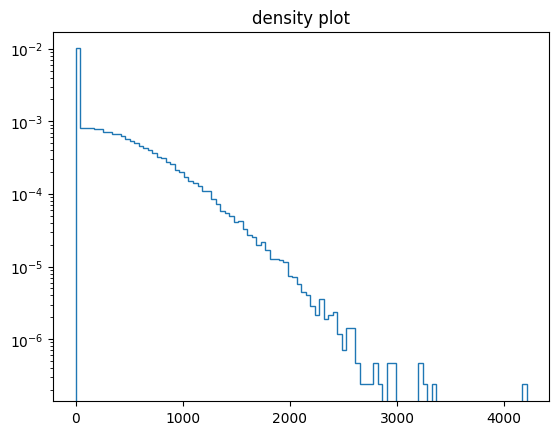

In [ ]:
pv_vec = stats["PV_VEC"]
plt.hist(pv_vec, bins=100, density=True, histtype="step", log=True)
plt.title("density plot")
plt.show()

## Suggested Exercises

- Add mean reversion to the model
- Add a jump process to the model
- Change the model to a normal (Bachelier) process instead of log normal. This is often used for commodities where a negative price is admissible.

Next: [Create a Two Asset Black Scholes Model](2_2_custom_two_asset.ipynb)